In [16]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [17]:
import pandas as pd

In [18]:
df = pd.read_csv("datasets/Aggregation.txt", sep='\t', names=["x", "y", "cluster"])
df.head()

,x,y,cluster
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


In [19]:
np.random.seed(0)

In [20]:
clusters = np.array(df.cluster)
centroids = []
for cluster in np.unique(clusters):
    nodes = np.arange(df.shape[0])[clusters==cluster]
    centroids.append(np.random.choice(nodes, 1)[0])
print(centroids)

[753, 47, 541, 455, 757, 682, 179]


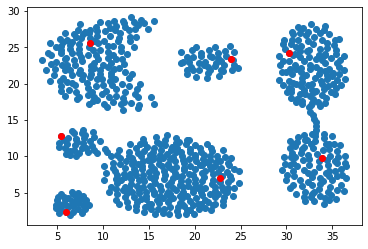

In [21]:
plt.figure()
plt.scatter(df.x, df.y)
plt.scatter(df.x.iloc[centroids], df.y.iloc[centroids], color='r')
plt.show()

In [22]:
positions = np.array(df[["x", "y"]])

In [23]:
def generate_edges(positions, radius=1):
     
    # initialize the edgelist
    N = positions.shape[0]
    idxs = np.arange(N)
    A = [[]]*N
    
    for i in range(N):
        point = positions[i,:]
        dists = np.linalg.norm(point-positions, axis=1)
        neighs = idxs[np.logical_and(dists<=radius, idxs!=i)]
        A[i] = []
        for j, neigh in enumerate(neighs):
            #A[i].append((neigh, 1./dists[idxs!=i][j]))
            A[i].append((neigh, 1))
    return A

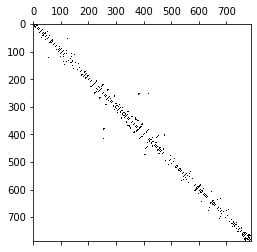

In [24]:
A = generate_edges(positions, 1.5)
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

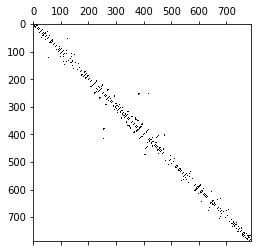

In [25]:
# generate the L matrix
L = localPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

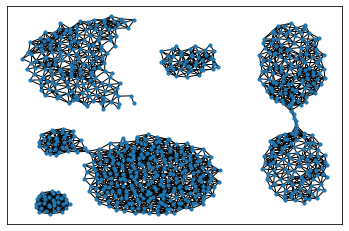

In [26]:
g = nx.Graph(A_mat)
plt.figure()
nx.draw_networkx(g, pos=positions, node_size=10, with_labels=False)
plt.show()

In [31]:
# compute the edgelist corresponding to L transposed
L_T = transposeEdgelist(L)

In [89]:
def cluster(L_T, A_mat=None, pos=None, colors=None, node_size=10, draw_edges=False):
    # initialize the vector of cluster ids
    clusters = - np.ones(len(L_T))
    
    for node in range(len(L_T)):
        if clusters[node]<0: 
            # initialize the current node and its cluster
            current_node = node
            clusters[node] = node

            # compute the path
            exit = False
            while not exit:
                next_node = max(L_T[current_node], key=lambda x: x[1])[0]
                if  clusters[next_node]<0:
                    clusters[next_node] = node
                    current_node = next_node
                else:
                    clusters[clusters==node] = clusters[next_node]
                    exit = True

    pos, colors = plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
        
    return clusters

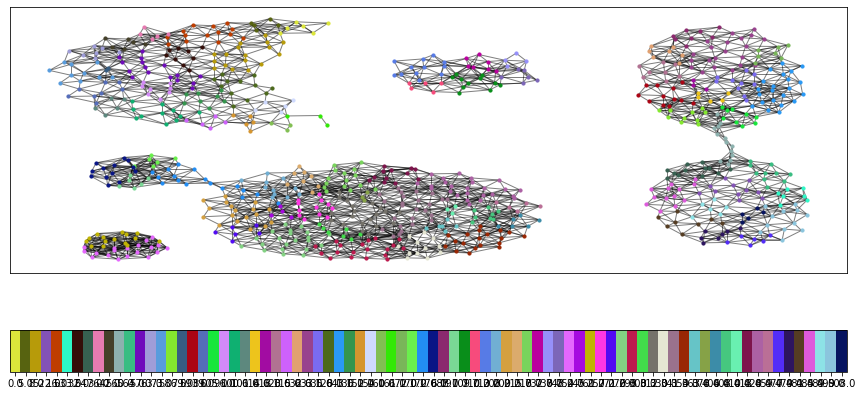

array([  0.,   0.,   0.,   0.,   0.,   5.,   5.,   0.,   8.,   8.,   5.,
         5.,   5.,   8.,   8.,   8.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,  32.,
        16.,  16.,  16.,  36.,  36.,  16.,  36.,  36.,  36.,  42.,  42.,
        42.,  16.,  32.,  32.,  32.,  32.,  32.,  32.,   8.,   8.,   8.,
        32.,  32.,  57.,  57.,  57.,  42.,  42.,  42.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  57.,  57.,  57.,  73.,  73.,  73.,  73.,
        73.,  73.,  79.,  79.,  57.,  57.,  57.,  57.,  73.,  73.,  73.,
        73.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  96.,  96.,  96.,
        96., 100., 101., 101.,  89., 101., 101., 101., 100., 100., 100.,
        96., 100., 100., 100., 100., 115., 100., 100., 115., 115.,  96.,
        96.,  96.,  57.,  57.,  57.,  57.,  57., 128., 128.,   8.,   8.,
       128., 128., 128., 128., 136.,  57., 136., 136., 136., 136., 136.,
       128., 128., 128., 128., 128., 136., 136., 10

In [91]:
cluster(L_T, A_mat, pos=positions, colors=None, node_size=10, draw_edges=True)